In [1]:
# Basics
import numpy as np
import random
import json
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Custom
import sys
sys.path.insert(0, '../../src/utils')
# from data_loader import DataLoader, SplitDataLoader
import constants
# import visualization as vis
sys.path.insert(0, '../../src/modeling')
from hp_tuner import HPTuner
# from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

# DataLoader & Network

In [2]:
# Basics
import trsfile
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import random

# Custom
import aes
import constants


class DataLoader():
    
    """
    Trace loading and labeling.
    
    Attributes:
        - trace_files (str list):
            Paths to the trace files.
        - n_tr_per_config (int):
            Number of traces to be collected per different device-key configuration.
        - target (str):
            Target of the attack.
        - n_classes (int):
            Number of possible labels.
        - byte_idx (int, default=None):
            Byte index to consider during the labeling of the traces.
        - scaler (sklearn.preprocessing.StandardScaler):
            Scaler used to scale the values of the traces.
           
    Methods:
        - _retrieve_metadata:
            Collects the plaintext and the key used during encryption and 
            produces the labels.
        - _shuffle:
            Shuffles the traces and their metadata (each trace mantains its own
            metadata).
        - load:
            Retrieves the values of the traces, the plaintexts and the keys and
            labels the traces.
    """


    def __init__(self, n_tot_traces, target, byte_idx=None, configs=['useless']):
    
        """
        Class constructor: and generates a DataLoader object (most of inputs are 
        not attributes).
        
        Parameters:
            - configs (str list):
                Device-keys configurations used during the encryption.
            - n_tot_traces (int):
                Total number of traces to retrieve.
            - target (str):
                Target of the attack.
            - byte_idx (int, default=None):
                Byte index considered during the labeling of the traces.
        """
        
        self.trace_files = ['/prj/side_channel/Pinata/CURR/swMaskedAES/D3-K7_round1_500MHz + Resampled.trs']
                            
        self.n_tr_per_config = int(n_tot_traces / len(configs))
        
        self.target = target
        self.n_classes = constants.N_CLASSES[target]
        
        self.byte_idx = byte_idx
        
        self.scaler = StandardScaler()
        
    
    def _retrieve_metadata(self, tr):

        """
        Collects the plaintext and the key used during encryption and produces 
        the labels.
        
        If a not-None byte index is specified in the constructor, then only a 
        single byte of the plaintext and of the key is retrieved.
        
        Parameters:
            - tr (trsfile.trace.Trace):
                Trace whose metadata must be retrieved.
        
        Returns:
            - l, p, k (tuple):
                l is the label associated to the trace.
                p is the plaintext used during the encryption (eventually single
                bytes).
                k is the key used during the encryption (eventually single bytes).
        """
        
        p = np.array(tr.get_input()) # int list
        k = np.array(tr.get_key()) # int list
        l = aes.labels_from_key(p, k, self.target) # Compute the set of 16 labels

        if self.byte_idx is not None:
            l = l[self.byte_idx]
            p = p[self.byte_idx]
            k = k[self.byte_idx]

        l = to_categorical(l, self.n_classes)
        
        return l, p, k
        
        
    @staticmethod
    def _shuffle(x, y, pbs, tkbs):
        
        """
        Shuffles the traces and their metadata (each trace mantains its own
        metadata).
        
        Parameters:
            - x (np.ndarray):
                Values of the traces.
            - y (np.ndarray):
                Labels of the traces (one-hot-encoded).
            - pbs (np.array or np.ndarray):
                Plaintexts (eventually single bytes).
            - tkbs (np.array or np.ndarray):
                Keys (eventually single bytes).
                
        Returns:
            - x, y, pbs, tkbs (tuple):
                Shuffled input where the relation between trace and metadata is
                kept (meaning that each trace is related to its own metadata).
        """

        to_shuffle = list(zip(x, y, pbs, tkbs))
        random.shuffle(to_shuffle)
        x, y, pbs, tkbs = zip(*to_shuffle)
        
        x = np.array(x)
        y = np.array(y)
        pbs = np.array(pbs)
        tkbs = np.array(tkbs)
        
        return x, y, pbs, tkbs
        
        
    def load(self):
    
        """
        Retrieves the values of the traces, the plaintexts and the keys and
        labels the traces.
        
        The values of the traces are scaled with a StandardScaler (resulting 
        data have mean=0, var=1).
        
        Returns:
            - x, y, pbs, tkbs (tuple):
                x contains the scaled values of the traces.
                y contains the one-hot-encoded labels of the traces.
                pbs contains the plaintexts of the traces (eventually single 
                bytes).
                tkbs contains the keys of the traces (eventually single bytes).
        """
    
        samples = []
        labels = []
        pltxt_bytes = []
        true_key_bytes = []
        
        for tfile in self.trace_files:
            with trsfile.open(tfile, 'r') as traces:
                for tr in traces[:self.n_tr_per_config]:
                    s = tr.samples
                    l, p, k = self._retrieve_metadata(tr)
                    samples.append(s)
                    labels.append(l)
                    pltxt_bytes.append(p)
                    true_key_bytes.append(k)
                    
        x = np.array(samples) # (n_tot_traces x trace_len)
        x = self.scaler.fit_transform(x)
        y = np.array(labels) # (n_tot_traces x n_classes)
        pbs = np.array(pltxt_bytes) # (n_tot_traces x 1)
        tkbs = np.array(true_key_bytes) # (n_tot_traces x 1)
        
        x, y, pbs, tkbs = self._shuffle(x, y, pbs, tkbs)
        
        if len(self.trace_files) == 1:
            tkbs = tkbs[0] # All true_key_bytes are equal because the config is unique 
            
        return x, y, pbs, tkbs
        
        
class SplitDataLoader(DataLoader):

    """
    Subclass of DataLoader used to directly split data into train and validation
    sets.
    
    Additional parameters:
        - n_train_tr_per_config (int):
            Number of train-traces to be collected per different device-key 
            configuration.

    Overwritten methods:
        - load:
            Retrieves the values of the traces, the plaintexts and the keys and
            labels the traces.
            In addition, splits the data into train and validation sets.
    """
   
    def __init__(self, n_tot_traces, train_size, target, byte_idx=None, configs=['useless']):
    
        """
        Class constructor: and generates a SplitDataLoader object (most of inputs 
        are not attributes).
        
        Parameters:
            - configs (str list):
                Device-keys configurations used during the encryption.
            - n_tot_traces (int):
                Total number of traces to retrieve.
            - train_size (float):
                Size of the train-set expressed as percentage.
            - target (str):
                Target of the attack.
            - byte_idx (int, default=None):
                Byte index considered during the labeling of the traces.
        """
        
        super().__init__(n_tot_traces, target, byte_idx, configs)
        
        self.n_train_tr_per_config = int(train_size * self.n_tr_per_config)
        
        
    def load(self):
    
        """
        Retrieves the values of the traces, the plaintexts and the keys and
        labels the traces.
        In addition, splits the data into train and validation sets.
        
        Proportions are kept in both sets: in the train set there are i traces
        per configuration, while in the validation set there are j < i traces 
        per configuration.
        
        Returns:
            - train_data, val_data (tuple):
                Train set and validation set with values of the traces, labels,
                plaintexts and keys (plaintexts and keys eventually as single 
                bytes).
        """
    
        x_train = []
        y_train = []
        pbs_train = []
        tkbs_train = []
        
        x_val = []
        y_val = []
        pbs_val = []
        tkbs_val = []
        
        for tfile in self.trace_files:
            
            config_s = []
            config_l = []
            config_p = []
            config_k = []
            
            with trsfile.open(tfile, 'r') as traces:
                for tr in traces[:self.n_tr_per_config]:
                    s = tr.samples
                    l, p, k = self._retrieve_metadata(tr)
                    
                    config_s.append(s)
                    config_l.append(l)
                    config_p.append(p)
                    config_k.append(k)
            
            x_train.append(config_s[:self.n_train_tr_per_config])
            x_val.append(config_s[self.n_train_tr_per_config:])
            
            y_train.append(config_l[:self.n_train_tr_per_config])
            y_val.append(config_l[self.n_train_tr_per_config:])
            
            pbs_train.append(config_p[:self.n_train_tr_per_config])
            pbs_val.append(config_p[self.n_train_tr_per_config:])
            
            tkbs_train.append(config_k[:self.n_train_tr_per_config])
            tkbs_val.append(config_k[self.n_train_tr_per_config:])
        
        # Reduce the lists of arrays to a single np.ndarray
        x_train = np.concatenate(x_train)
        y_train = np.concatenate(y_train)
        pbs_train = np.concatenate(pbs_train)
        tkbs_train = np.concatenate(tkbs_train)
        
        x_val = np.concatenate(x_val)
        y_val = np.concatenate(y_val)
        pbs_val = np.concatenate(pbs_val)
        tkbs_val = np.concatenate(tkbs_val)
        
        # Scale the whole train-set (train + val) with the same scaler
        n_tot_train = x_train.shape[0] # train_size * n_tot_traces
        x_tot = np.concatenate([x_train, x_val])
        x_tot = self.scaler.fit_transform(x_tot)
        x_train = x_tot[:n_tot_train]
        x_val = x_tot[n_tot_train:]
        
        # Shuffle the sets
        x_train, y_train, pbs_train, tkbs_train = self._shuffle(x_train, y_train, pbs_train, tkbs_train)
        x_val, y_val, pbs_val, tkbs_val = self._shuffle(x_val, y_val, pbs_val, tkbs_val) 
            
        # Create train and test packages
        train_data = (x_train, y_train, pbs_train, tkbs_train)
        val_data = (x_val, y_val, pbs_val, tkbs_val)
            
        return train_data, val_data

In [3]:
# Basic
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import L1, L2, L1L2

# Custom
import sys
sys.path.insert(0, '../utils')
import aes
import constants


class Network():

    """
    Neural Network implementation.
    
    Attributes:
        - model_type (str):
            Type of Neural Network to implement.
        - hp (dict):
            Neural Network hyperparameters.
        - model (keras.models.Sequential):
            Neural Network model.
            By default, it is an empty Sequential object.
        - callbacks (keras.callbacks list):
            List of callbacks to use during model training.
            By default, EarlyStopping and ReduceLROnPlateau are considered.
            
    Methods:
        - add_checkpoint_callback:
            Adds ModelCheckpoint to the list of callbacks.
        - build model:
            Generates the Neural Network model.
        - _compute_key_preds:
            Converts target-predictions into key-predictions.
        - _compute_final_ranking:
            Generates the final ranking of all possible key-bytes.
        - ge:
            Computes the Guessing Entropy of an attack.
    """

    def __init__(self, model_type, hp):

        """
        Class constructor: takes as input all class attributes and generates a
        Network object.
        """
    
        self.model_type = model_type
        self.hp = hp
        self.model = Sequential()
        
        self.callbacks = [
            EarlyStopping(
                monitor='val_loss', 
                patience=15
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=7,
                min_lr=1e-7),
        ]
        

    def add_checkpoint_callback(self, model_path):
    
        """
        Adds ModelCheckpoint to the list of callbacks.
        
        ModelCheckpoint allows to save the best-performing model during training
        (performance is given by the validation loss (the lower, the better)).
        
        Parameters:
            - model_path (str):
                Path to where to store the model (model is a H5 file).
        """
        
        self.callbacks.append(
            ModelCheckpoint(
                model_path,
                monitor='val_loss',
                save_best_only=True
            )
        )


    def build_model(self):
    
        """
        Generates the Neural Network model adding layer to the default empty
        Sequential object.
        
        Different models can be generated: MultiLayer Perceptron (MLP) or 
        Convolutional Neural Network (CNN).
        """

        if self.model_type == 'MLP':
        
            #### Architecture: ####
            # Input Dense         #
            # Input BatchNorm     #
            #                     #
            # repeat(             #
            #   Hidden Dropout    #
            #   Hidden Dense      #
            #   Hidden BatchNorm  #
            # )                   # 
            #                     #
            # Output Dropout      #
            # Output Dense        #
            # Output BatchNorm    #
            #######################
    
            # Input Dense
            self.model.add(Dense(8871, activation='relu'))
            # Input BatchNorm
            self.model.add(BatchNormalization())

            # Hidden
            for _ in range(self.hp['hidden_layers']):
                # Hidden Dropout
                self.model.add(Dropout(self.hp['dropout_rate']))
                # Hidden Dense
                self.model.add(Dense(
                    self.hp['hidden_neurons'], 
                    activation='relu',
                    kernel_regularizer=L2(self.hp['l2']))
                )
                # Hidden BatchNorm
                self.model.add(BatchNormalization())

            # Output
            # Output Dropout
            self.model.add(Dropout(self.hp['dropout_rate']))
            # Output Dense with BatchNorm before activation
            self.model.add(Dense(256))
            self.model.add(BatchNormalization())
            self.model.add(Activation('softmax'))
            
            # Compilation
            lr = self.hp['learning_rate']
            if self.hp['optimizer'] == 'adam':
                opt = Adam(learning_rate=lr)
            elif self.hp['optimizer'] == 'rmsprop':
                opt = RMSprop(learning_rate=lr)
            else:
                opt = SGD(learning_rate=lr)
            
            self.model.compile(
                optimizer=opt, 
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
    
        else:
            pass # In future there will be CNN


    def _compute_key_preds(self, preds, key_bytes):
    
        """
        Converts target-predictions into key-predictions (key-byte).

        Parameters:
            - preds (np.ndarray):
                Target-predictions (probabilities for each possible target value).
            - key_bytes (np.array):
                Key-bytes relative to each possible value in the target-predictions.
                Target-predictions cover all possible values (1 to 255), and
                each value leads to a differnt key-byte.
        
        Returns:
            - key_preds (np.array):
               Key-predictions (probabilities for each possible key-byte value).
        """
        
        # Associate each sbox-out prediction with its relative key-byte
        association = list(zip(key_bytes, preds))
        
        # Sort the association w.r.t. key-bytes (alignment for all traces)
        association.sort(key=lambda x: x[0])
        
        # Consider the sorted sbox-out predictons as key-byte predictons
        key_preds = list(zip(*association))[1]
        
        return key_preds
        
        
    def _compute_final_ranking(self, key_preds):
    
        """
        Generates the ranking of the key-bytes starting from key-predictions.
        
        Parameters:
            - key_preds (np.ndarray):
                Predictions relative to the key-byte (probabilities relative to
                each possible key-byte).
                
        Returns:
            - sorted_kbs (np.array):
                Ranking of the possible key-bytes (from the most probable to the 
                least probable).
        """
    
        log_probs = np.log10(key_preds + 1e-22)
        cum_tot_probs = np.cumsum(log_probs, axis=0)
        
        indexed_cum_tot_probs = [list(zip(range(256), tot_probs))
                                 for tot_probs in cum_tot_probs]
                                
        sorted_cum_tot_probs = [sorted(el, key=lambda x: x[1], reverse=True)
                                for el in indexed_cum_tot_probs]
                                
        sorted_kbs = [[el[0] for el in tot_probs]
                      for tot_probs in sorted_cum_tot_probs]
                      
        return sorted_kbs


    def ge(self, preds, pltxt_bytes, true_key_byte, n_exp, n_traces, target):
    
        """
        Computes the Guessing Entropy of an attack as the average rank of the 
        correct key-byte among the predictions.
        
        Parameters: 
            - preds (np.ndarray):
                Target predictions.
            - pltxt_bytes (np.array):
                Plaintext used during the encryption (single byte).
            - true_key_byte (int):
                Actual key used during the encryption (single byte).
            - n_exp (int):
                Number of experiment to compute the average value of GE.
            - n_traces (int):
                Number of traces to consider during GE computation.
            - target (str):
                Target of the attack.
                
        Returns:
            - ge (np.array):
                Guessing Entropy of the attack.
        """
        
        # Consider all couples predictions-plaintext
        all_preds_pltxt = list(zip(preds, pltxt_bytes))
        
        ranks_per_exp = []
        for _ in range(n_exp):
            
            # During each experiment:
            #   * Consider only a fixed number of target-predictions
            #   * Retrieve the corresponding key-predictions
            #   * Compute the final key-predictions
            #   * Rank the final key-predictions
            #   * Retrieve the rank of the correct key (key-byte)
            
            sampled = random.sample(all_preds_pltxt, n_traces)
            sampled_preds, sampled_pltxt_bytes = list(zip(*sampled))
            
            if target == 'KEY':
                # If the target is 'KEY', then key_preds is directly sampled_preds
                # because sampled_preds contains predictions related to each key-byte
                # already in order
                key_preds = preds
            else: 
                # SBOX-IN, SBOX-OUT, ... need further computations
                key_bytes = [aes.key_from_labels(pb, target) for pb in sampled_pltxt_bytes]
            
                key_preds = np.array([self._compute_key_preds(ps, kbs) 
                                      for ps, kbs in zip(sampled_preds, key_bytes)])
                                
            final_ranking = self._compute_final_ranking(key_preds)
            
            true_kb_ranks = np.array([kbs.index(true_key_byte)
                                      for kbs in final_ranking])
            
            ranks_per_exp.append(true_kb_ranks)
            
        # After the experiments, average the ranks
            
        ranks_per_exp = np.array(ranks_per_exp)
        ge = np.mean(ranks_per_exp, axis=0)
        
        return ge


# Attack

In [4]:
BYTE_IDX = 0
EPOCHS = 100
TARGET = 'SBOX_OUT'

In [5]:
train_dl = SplitDataLoader( 
    n_tot_traces=100000,
    train_size=0.9,
    target=TARGET,
    byte_idx=BYTE_IDX
)
train_data, val_data = train_dl.load()
x_train, y_train, _, _ = train_data 
x_NOT_train, y_NOT_train, pbs_NOT_train, tkbs_NOT_train = val_data

x_val = x_NOT_train[:6000]
y_val = y_NOT_train[:6000]
_ = pbs_NOT_train[:6000]
_ = tkbs_NOT_train[:6000]

x_test = x_NOT_train[6000:]
y_test = y_NOT_train[6000:]
pbs_test = pbs_NOT_train[6000:]
tkbs_test = tkbs_NOT_train[6000:]

In [19]:
HP = {
    "hidden_layers": 1, 
    "hidden_neurons": 200, 
    "dropout_rate": 0.4, 
    "l2": 0.001, 
    "optimizer": "adam", 
    "learning_rate": 1e-3, 
    "batch_size": 256
}

In [20]:
attack_net = Network('MLP', HP)
attack_net.build_model()
# saved_model_path = f'{res_path}/{n_devs}d/{n_keys}k/best_model_{"".join(train_devs)}vs{test_dev}__{tuning_method}.h5'
# attack_net.add_checkpoint_callback(saved_model_path)
model = attack_net.model

#Training (with Validation)
history = model.fit(
    x_train, 
    y_train, 
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    batch_size=attack_net.hp['batch_size'],
    callbacks=attack_net.callbacks,
    verbose=1
).history

2022-09-07 17:29:23.586750: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.97GiB (rounded to 3193560064)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-07 17:29:23.587566: W tensorflow/core/common_runtime/bfc_allocator.cc:474] ************************************________********************************************************


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

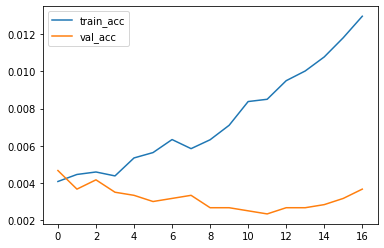

In [9]:
plt.plot(history['accuracy'], label='train_acc')
plt.plot(history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [10]:
preds = model.predict(x_test)

In [11]:
ge = attack_net.ge(
    preds=preds, 
    pltxt_bytes=pbs_test, 
    true_key_byte=tkbs_test[0], 
    n_exp=100, 
    n_traces=10, 
    target=TARGET
)

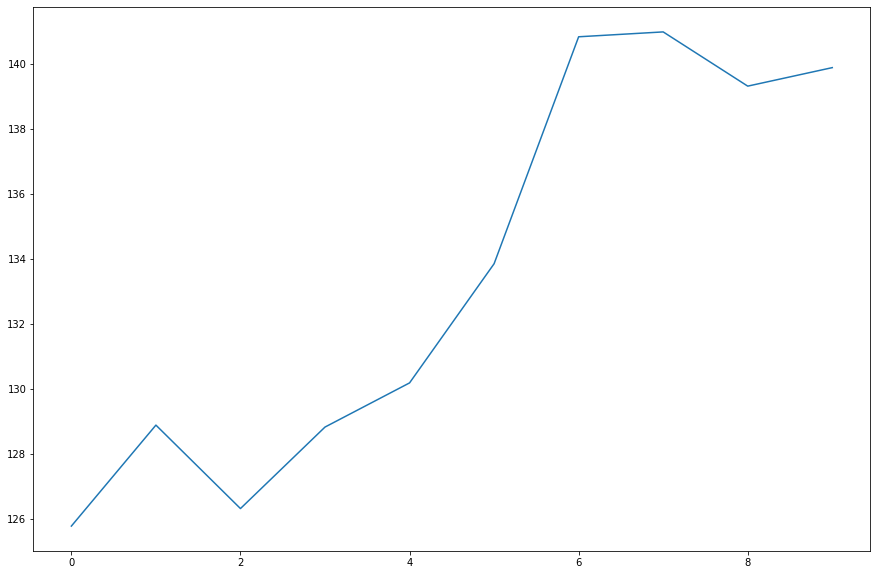

In [12]:
f, ax = plt.subplots(figsize=(15,10))
ax.plot(ge)
plt.show()